## Coherence Estimates

In [4]:
import scqubits as scq
import matplotlib.pyplot as plt
import numpy as np

Circuits defined through the `Circuit` objects have the ablity to provide estimates for coherence times. `scqubits` does this by generating methods associated with various, potentially relevant noise channels (similiariy to what is done for other pre-defined qubits and circuits - see [here](../../noise/guide-noise.rst) for details). These methods depend on the topology of the circuit and specific branch types (e.g., capacitive, indcutive or one containing a Josephson junction), as well as flux-loops that the circuit contains. 

Let us considder an example "Snail" circuit configuration

In [5]:
snail_yaml = """
branches:
- [JJ, 0, 1, 90, EC1=0.2]
- [JJ, 1, 2, 90, EC3=0.2]
- [JJ, 2, 3, 90, 0.2]
- [JJ, 3, 0, 15, 0.2]
- [C, 3, 0, 0.3]
"""

which we can realize with

In [6]:
circ = scq.Circuit(snail_yaml, from_file=False, use_dynamic_flux_grouping=True, generate_noise_methods=True)

There two important arguments that are passed to `Circuit` constructor which determine if and how noise can calculated:

`generate_noise_methods`: A boolean argument that determines whether methods for estimating coherences are generated for this object. 

`use_dynamic_flux_grouping`: A boolean argument that determines if a flux-grouping based on this [You at al. PRB(2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.174512) (or [arXiv](https://arxiv.org/abs/1902.04734)) paper is generated. This grouping approach is recemmendd any time flux is assumed to have time-dependence (due to noise, or otherwise) as it aims to group flux among different branches in a way that would not require a term proportional to the flux-derviative. 


.. warning::
If `generate_noise_methods` is not set to `True` when building a `Circuit` object, none of the cohernece methods will be generated. Users can however, choose to genrate them at a later time by executing `circ.configure(generate_noise_methods=True)`. 

.. warning::
If `use_dynamic_flux_grouping` is not set to `True` when estimating coherence times, to obtain results related to flux noise, `scqubits` will utilize a more arbitrary grouping, and not the one proposed by [You at al. PRB(2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.174512). 


### Auto-generated `supported channels`
The `circ` object now contains a variety of `supported_noise_methods` wich can be explictiy listed with:

In [29]:
circ.supported_noise_channels()

['tphi_1_over_f_flux1',
 'tphi_1_over_f_ng1',
 'tphi_1_over_f_ng2',
 'tphi_1_over_f_ng3',
 'tphi_1_over_f_cc0',
 'tphi_1_over_f_cc1',
 'tphi_1_over_f_cc2',
 'tphi_1_over_f_cc3',
 't1_flux_bias_line1',
 't1_capacitive0',
 't1_capacitive1',
 't1_capacitive2',
 't1_capacitive3',
 't1_capacitive4',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 'tphi_1_over_f_ng',
 't1_capacitive',
 't1_flux_bias_line']

In the above we see that `scqubits` generates relevant methods for each branch or flux-loop (those are indexed with a branch or loop number at the end of method's name) but also adds a collective method, one for earch noise type. For example, as there are four Joesphosn junctions in our circuit, we have `tphi_1_over_f_ccX`, with `X=0,1,2,3` representing branch indices (that can be listed with `circ.branches`), as well as `tphi_1_over_f_cc`, which combines the effects of the critical current $1/f$ noise from all four junctions (through addition of the rates correspoding to each). 

The types of methods that are currently included are: `tphi_1_over_f_cc`, `tphi_1_over_f_flux`, `tphi_1_over_f_ng`, `t1_capacitive`, `t1_flux_bias_line` - see the `scqubits` noise [documentation](../../noise/guide-noise.rst) for the description and details of the noise channel that each corresponds to.

.. note::
Quasiparticle noise, captured by the method `t1_quasiparticle_tunneling` (see [here](../../noise/guide-noise.rst)) has not yet been implemented, but will be at a later date.


### Calculating and plotting coherence effects from different noise channels

Calculating coherence times due to specific noise channels acting on particular branches or loops is done calling the corresponding methods.

.. note:: Coherence methods implemented by the `Circuit` class behave the same way as those implemented by other predefind qubits and circuits (e.g, Transmon, Fluxonium, etc.), and retain the same flexibility (i.e., their default parameters can be be easily modified)

Let us remember what the indices of each of the branches are

In [30]:
circ.branches

[Branch(JJ, 0, 1, id_str: 0),
 Branch(JJ, 1, 2, id_str: 1),
 Branch(JJ, 2, 3, id_str: 2),
 Branch(JJ, 3, 0, id_str: 3),
 Branch(C, 3, 0, id_str: 4)]

and look at the depolarizaion $T_1$ time, at temperature of 0.1 mK, due to the capacitor between nodes 0 and 3 (i.e., of branch 4), but only including contributions from the downward rate between levels 2 and 1:

In [31]:
circ.t1_capacitive(2,1, total=False, T=0.100, Q_cap=1e6)

17778.29790642468

By defeault `scqubits` creates capactive based loss methods for all the Josephson junctions, with the same default parameters that for the stand-alone capacitors. Those however can be easily modified. For example, one can define a custom frequency-dependent quality factor, as in the following

In [32]:
def custom_q_cap_fun(omega, T):
    return 1e6 * (2 * np.pi * 6e9 / np.abs(scq.to_standard_units(omega))) ** 0.85

circ.t1_capacitive2(Q_cap = custom_q_cap_fun)

199703.34548851577

Alternatively we can look at the dephasing time, due to the $1/f$ critical current noise in *all* the junctions (note there is no branch index at the end of the methode name, hence the contributions from all the rates corresponding to this type of noise are included), here with all the default parameters

In [8]:
circ.tphi_1_over_f_cc()

2308488.4887882355

Plotting is also done in the same way as in for the predefind qubits or circuits. For example let us consider a couple of noise channels, but add some custom scaling, and figure title

Spectral data:   0%|          | 0/51 [00:00<?, ?it/s]

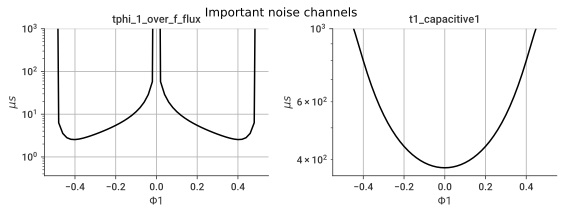

In [34]:
fig, ax = circ.plot_coherence_vs_paramvals(
    param_name="Φ1",
    param_vals=np.linspace(-0.5, 0.5, 51),
    noise_channels=['tphi_1_over_f_flux', 't1_capacitive1'],
    scale=1e-3,
    ylabel=r"$\mu s$",
    color='black',
    ylim=(None, 1e3)
)
fig.suptitle("Important noise channels");

### Calculating and plotting the "effective" noise effects
By default when plotting the "effective" coherence times, the noise contributions from all branches and loops are included

In [35]:
circ.t1_effective()

27824.791750682736

However, if desidred, only subsets of channels can be included (each with their own non-default parameters - see [here](../../noise/guide-noise.rst) for more details)

In [36]:
circ.t2_effective(noise_channels=['t1_flux_bias_line','t1_capacitive', ('tphi_1_over_f_flux', dict(A_noise=3e-6))], common_noise_options=dict(T=0.050))

55586.75401900446

Plotting the effective noise contributions is done in a similar way, and various non-default noise channels, and/or their parameters can be readily specified 

Spectral data:   0%|          | 0/51 [00:00<?, ?it/s]

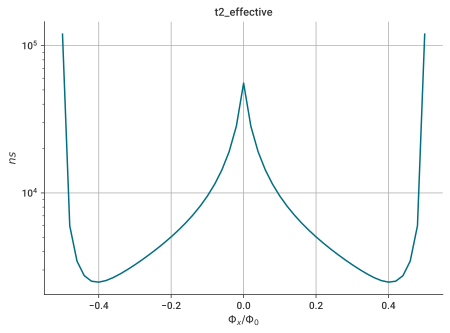

In [37]:
circ.plot_t2_effective_vs_paramvals(param_name='Φ1',
                            param_vals=np.linspace(-0.5, 0.5, 51),
                            noise_channels=['t1_capacitive', 't1_flux_bias_line',
                                            ('tphi_1_over_f_flux', dict(A_flux=3e-6))],
                            common_noise_options=dict(T=0.050),
                            xlabel=r"$\Phi_x/\Phi_0$",
                            grid='red' # custom grid
                            );